In [1]:
from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.metrics import signal_power, calcLLR, fastBERcalc
from optic.fec import ldpcEncode, ldpcDecode
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import io
from tqdm.notebook import tqdm
from numba import njit

import os.path as path

In [2]:
from commpy.channelcoding import ldpc
from commpy.channelcoding.ldpc import triang_ldpc_systematic_encode as encodeLDPC
from commpy.channelcoding.ldpc import ldpc_bp_decode as decodeLDPC
from commpy.channelcoding.interleavers import RandInterlv

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
@njit
def awgn(tx, noiseVar):
    
    σ        = np.sqrt(noiseVar)
    noise    = np.random.normal(0,σ, tx.size) + 1j*np.random.normal(0,σ, tx.size)
    noise    = 1/np.sqrt(2)*noise
    
    rx = tx + noise
    
    return rx

## Create LDPCparam files

In [5]:
# pathdir = r'C:\Users\edson.DESKTOP-54IJM4F\Desktop\DVBS2'

# d = sp.io.loadmat(pathdir+'\LDPC_ARJA_1280b_R45.mat')
# H = d['H']

# # H = d['LDPC']['H'] # parity check matrix
# # H = H[0][0][0][0][0]
# H = sp.sparse.csr_matrix.todense(H).astype(np.int8)
# H = np.asarray(H)

# file_path = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\OptiCommPy-private\optic\fecParams\LDPC_ARJA_1280b_R45.txt'

# ldpc.write_ldpc_params(H, file_path)

In [6]:
# FEC parameters
family = "DVBS2"
R = 56
n = 64800

mainDir  = path.abspath(path.join("../")) 
filename = '\LDPC_' + family + '_' + str(n) + 'b_R' + str(R) + '.txt'
filePath = mainDir + r'\optic\fecParams' + filename
filePath

'C:\\Users\\edson\\OneDrive\\Documentos\\GitHub\\OptiCommPy-private\\optic\\fecParams\\LDPC_DVBS2_64800b_R56.txt'

In [7]:
#LDPCparams['filemane'][12:]

In [8]:
# Run AWGN simulation 
EbN0dB = 10
M      = 64
Nwords = 16
nIter  = 10

# FEC parameters
LDPCparams = ldpc.get_ldpc_code_params(filePath)
K = LDPCparams['n_vnodes'] - LDPCparams['n_cnodes']

LDPCparams['filename'] = filename

# modulation parameters
constSymb = GrayMapping(M,'qam')[:,0]        # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = signal_power(constSymb)                 # mean symbol energy

# generate random bits
bits = np.random.randint(2, size = (K, Nwords))

# encode data bits with LDPC soft-FEC
bitsTx, codedBitsTx, interlv = ldpcEncode(bits, LDPCparams)

# Map bits to constellation symbols
symbTx = modulateGray(bitsTx, M, 'qam')

# Normalize symbols energy to 1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# AWGN    
snrdB    = EbN0dB + 10*np.log10(np.log2(M))
noiseVar = 1/(10**(snrdB/10))

symbRx = awgn(symbTx, noiseVar)

# pre-FEC BER calculation (hard demodulation)
BER, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
print('BER = %.2e'%BER[0])

# soft-demodulation
llr = calcLLR(symbRx, noiseVar, constSymb/np.sqrt(Es), bitMap)

# soft-FEC decoding
decodedBits, llr_out = ldpcDecode(llr, interlv, LDPCparams, nIter, alg="SPA")

# post-FEC BER calculation
BERpost = np.mean(np.logical_xor(bits, decodedBits[0:K,:]))

print('BERpostFEC = %.2e'%BERpost)
print('Number of bits = ', decodedBits.size)

BER = 2.67e-02
BERpostFEC = 0.00e+00
Number of bits =  1036800


In [22]:
Nwords = 16
nIter  = 50

# FEC parameters
LDPCparams = ldpc.get_ldpc_code_params(filePath)
LDPCparams['filename'] = filename
K = LDPCparams['n_vnodes'] - LDPCparams['n_cnodes']

# Run BER vs Ebn0 Monte Carlo simulation 
qamOrder  = [64]  # Modulation order
EbN0dB_  = np.arange(7, 9.5, 0.05)

BERpre   = np.zeros((len(EbN0dB_),len(qamOrder)))
BERpost  = np.zeros((len(EbN0dB_),len(qamOrder)))

BERpre[:]  = np.nan
BERpost[:] = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    
    # modulation parameters
    constSymb = GrayMapping(M,'qam')[:,0]        # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))
    Es = signal_power(constSymb) # mean symbol energy

    for indSNR in tqdm(range(EbN0dB_.size)):
        
        EbN0dB = EbN0dB_[indSNR]
        
        # generate random bits
        bits = np.random.randint(2, size = (K, Nwords))

        # encode data bits with LDPC soft-FEC
        bitsTx, codedBitsTx, interlv = ldpcEncode(bits, LDPCparams)

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN    
        snrdB    = EbN0dB + 10*np.log10(np.log2(M))
        noiseVar = 1/(10**(snrdB/10))

        symbRx = awgn(symbTx, noiseVar)

        # pre-FEC BER calculation (hard demodulation)
        BERpre[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
        #print('BER = %.2e'%BERpre[indSNR, ii])

        # soft-demodulation
        llr = calcLLR(symbRx, noiseVar, constSymb/np.sqrt(Es), bitMap)

        # soft-FEC decoding
        decodedBits, llr_out = ldpcDecode(llr, interlv, LDPCparams, nIter, alg="SPA")

        # post-FEC BER calculation
        BERpost[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx, decodedBits))
        #print('BERpostFEC = %.2e'%BERpost[indSNR, ii])

run sim: M =  64


  0%|          | 0/50 [00:00<?, ?it/s]

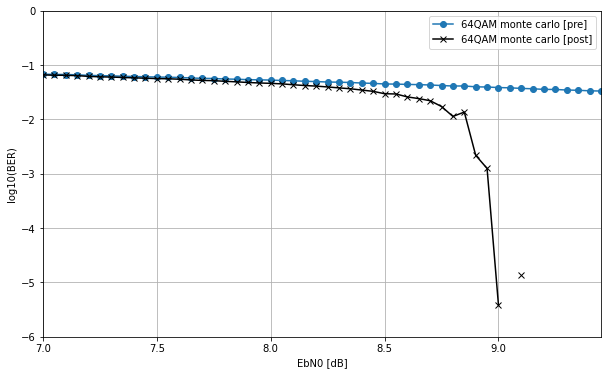

In [23]:
# Plot simulation results       
BERpre[BERpre==0] = np.nan
BERpost[BERpost==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BERpre[:,ii]),'o-', label=str(M)+'QAM monte carlo [pre]')

#plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BERpost[:,ii]),'kx-', label=str(M)+'QAM monte carlo [post]')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()